In [1]:
import re
import os
import math
import json
import jgraph

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from time import time
from pprint import pprint
from random import sample

from itertools import groupby
from itertools import combinations

from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from products import get_products

In [4]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [5]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [6]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## read products feed

In [7]:
from products import get_products
products = get_products()

In [8]:
from products import get_products_from_different_shops
sample_products = get_products_from_different_shops()
sample_products.shape

(73, 8)

## create sample dataset

In [9]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

In [10]:
dataset.data[['shop', 'ean', 'name', 'brand', 'type', 'price']].sort(['ean'])

/Users/jochen/miniconda3/envs/price_comparison/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,shop,ean,name,brand,type,price
9076,507,886111144150,HP - Hewlett Packard HP CF280X Toner Black -Ne...,HP - Hewlett Packard,Computer & Software > Toner & Druckerpatronen ...,126.14
317374,3790,886111144150,CF280X HP Toner Cartridge 80X,Hewlett Packard,IT Katalog 1 > Verbrauchsmaterial > Toner & Bi...,198.00
315617,3790,886111144150,HP CF280X Schwarz #80X,Hewlett-Packard GmbH,IT Katalog 2 > Verbrauchsmaterial > Toner HP >,184.00
303570,3530,886111144150,hp® hp Lasertoner/CF280X schwarz,hp®,Computer & Software > Toner & Druckerpatronen ...,204.20
326389,3927,886111144150,Hewlett Packard CF280X HP Toner Cartridge 80X,NaN,NaN,167.52
261091,2334,886111144150,HEWLETT PACKARD HP Cartridge No.80X Black (CF2...,HEWLETT PACKARD,Computer & Software > Toner & Druckerpatronen ...,168.36
257064,1956,886111144150,Hewlett Packard HP Toner CF280X Schwarz (ca. 6...,Hewlett Packard,Computer & Software > Toner & Druckerpatronen ...,182.46
253666,1858,886111144150,Hewlett Packard HP Toner CF 280 X schwarz No. ...,Hewlett Packard,Computer & Software > Drucker > Druckerzubehör...,158.99
308131,3751,4007123211210,Brennenstuhl 10xFach Steckdosenleiste Steckdos...,Brennenstuhl,"Elektronik, Foto & Optik > Elektronik Bauteile...",28.99
275643,2784,4007123211210,10er Brennenstuhl Primera-Line Technik schwarz,Brennenstuhl,Netzteile & USVs,17.35


## feature extraction

In [11]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [12]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [13]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [14]:
class WhitespaceRemover(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, regex='[^0-9a-zA-Z]+'):
        self.regex = re.compile(regex)
        
    def transform(self, data):
        return (self.regex.sub('', row) for row in data)        

In [15]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [16]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [17]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [18]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [19]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [20]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [21]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),
                    
            # Pipeline for pulling ngram features from the name column
            ('ngram_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name'])),
                ('whitespace_remove', WhitespaceRemover()),
                ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
            ('price', Pipeline([
                ('selector', ItemSelector(key='price')),
                ('price_distance', NumericDistance()),
                ('normalizer', Normalizer(copy=False)),
            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [22]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [23]:
#X = pipeline_distances.transform(dataset.data)
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

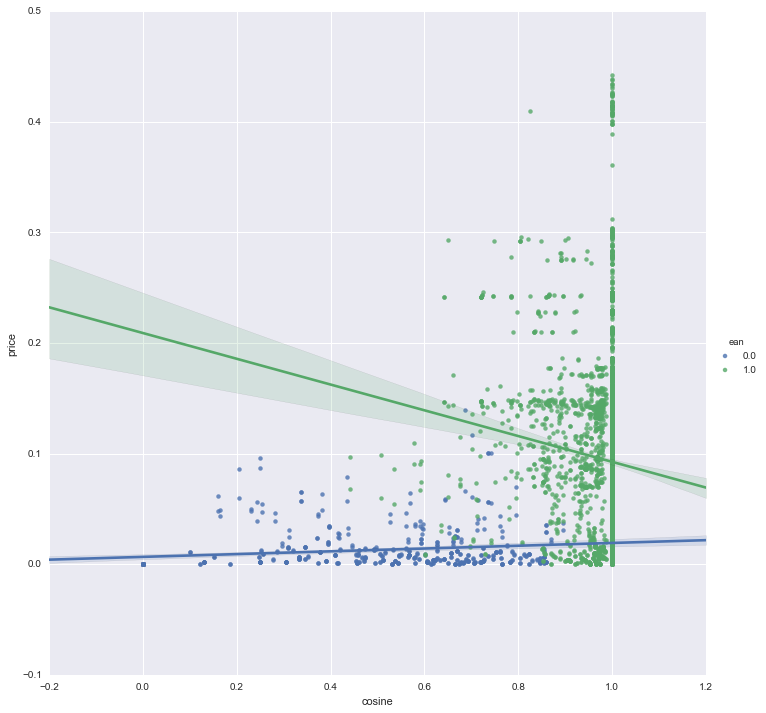

In [24]:
X_cosine_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[0][1].fit_transform(dataset.data).flatten()
X_ngram_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[1][1].fit_transform(dataset.data).flatten()
X_price_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[2][1].transform(dataset.data).flatten()
X_ean_dist = NumericDistance().transform(ItemSelector(key='ean').transform(dataset.data)).flatten()
X_ean_dist[X_ean_dist > 0] = 1
df = pd.DataFrame({'cosine': X_cosine_dist, 'price': X_price_dist, 'ngram': X_ngram_dist, 'ean': X_ean_dist})
#pp = sns.pairplot(df, hue="ean", vars=['cosine', 'price'], diag_kind="kde")
#sns.jointplot("cosine", "price", data=df, kind='scatter', size=10);
#sns.pairplot(df, x_vars=["cosine"], y_vars=["price"], hue="ean", size=10, kind="scatter")
sns.lmplot(x="cosine", y="price", hue="ean", data=df, size=10) # good

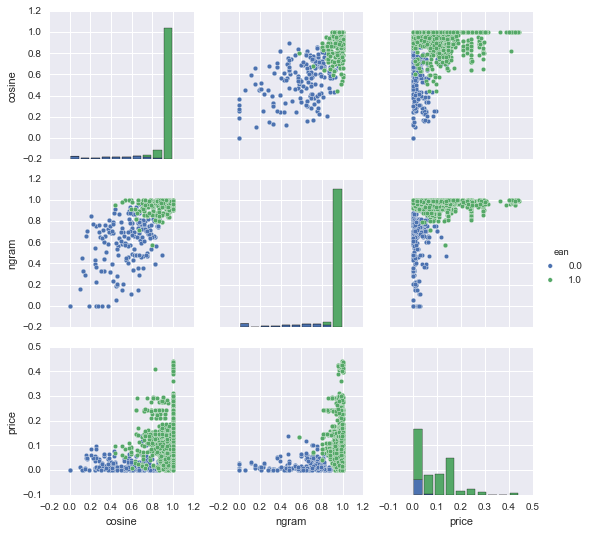

In [26]:
pp = sns.pairplot(df, hue="ean", vars=['cosine', 'ngram', 'price'], diag_kind="hist")

In [31]:
X_ngram_dist

array([ -2.22044605e-16,   1.00000000e+00,   1.00000000e+00, ...,
         9.79989386e-01,   9.82729786e-01,  -4.21884749e-15])

In [32]:
def match_kdeplot(df):
    sns.set(style="darkgrid")

    pos_cosine = df['cosine'][df['ean'] == 0]
    pos_price = df['price'][df['ean'] == 0]
    neg_cosine = df['cosine'][df['ean'] == 1]
    neg_cosine = neg_cosine[neg_cosine < 0.98]
    neg_price = df['price'][df['ean'] == 1]
    neg_price = neg_price[neg_price < 0.2][:neg_cosine.shape[0]]

    # Set up the figure
    f, ax = plt.subplots(figsize=(12, 10))
    #ax.set_aspect("equal")

    # Draw the two density plots
    ax = sns.kdeplot(pos_cosine, pos_price, cmap="Reds", shade=True, shade_lowest=False)
    ax = sns.kdeplot(neg_cosine, neg_price, cmap="Blues", shade=True, shade_lowest=False)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    ax.text(0.1, 0.02, "match", size=16, color=red)
    ax.text(0.6, 0.075, "non-match", size=16, color=blue)

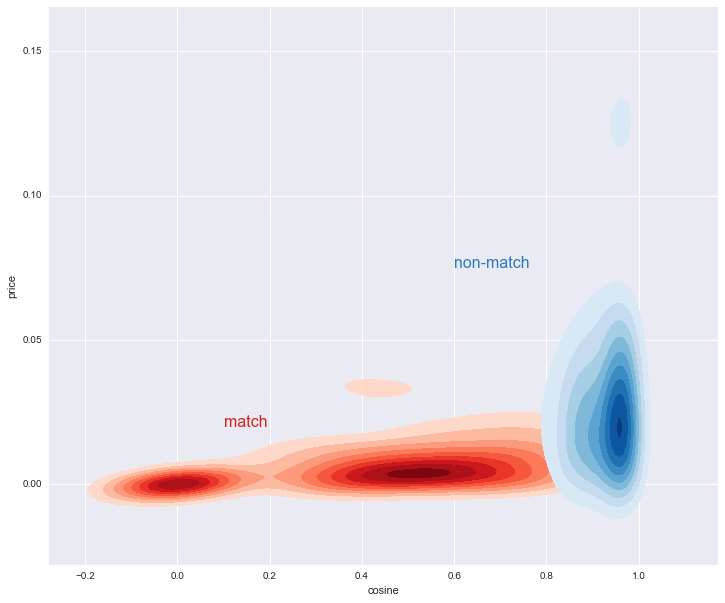

In [33]:
match_kdeplot(df)

In [34]:
pipeline_dbscan = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('dbscan', DBSCAN(eps=0.3, min_samples=3)),
    #('dbscan', SpectralClustering(n_clusters=dataset.true_k, eigen_solver='arpack')),
])

In [42]:
class Evaluation: 
    def __init__(self, pipeline, dataset):
        pipeline.fit(dataset.data)
        self.X = None
        try:
            self.X = pipeline.transform(dataset.data)
        except AttributeError as e:
            pass
        self.predicted = pipeline.predict(dataset.data)
            
        self.dataset = dataset
        
    def pairwise(self):
        """
        Takes two iterables of true and predicted labels and calculates
        the pairwise matches for each of them. For n samples there are
        n**2 pairs. Each pair is either a match or not. We are comparing
        the set of true matches/non-matches vs the set of the predicted
        matches/non-matches by treating them as results of a binary
        classification task and print out a classification report.
        """
        
        def all_combinations(ids):
            for a in ids:
                for b in ids:
                    yield a, b

        def matches_from_labels(labels):
            num = len(labels)
            pairwise = np.zeros(num ** 2).reshape(num, num)
            clusters = defaultdict(list)
            for idx, p in enumerate(labels):
                clusters[p].append(idx)
            for cluster in clusters.values():
                for i, j in all_combinations(cluster):
                    pairwise[i, j] = 1
            return pairwise.flatten()
    
        predicted_pairwise = matches_from_labels(self.predicted)
        true_pairwise = matches_from_labels(self.dataset.target)
        print(classification_report(true_pairwise, predicted_pairwise))
                
    def scores(self):
        """
        Just the usual suspects.
        """
        true, predicted = self.dataset.target, self.predicted
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(true, predicted))
        print("Completeness: %0.3f" % metrics.completeness_score(true, predicted))
        print("V-measure: %0.3f" % metrics.v_measure_score(true, predicted))
        print("Adjusted Rand-Index: %.3f"
              % metrics.adjusted_rand_score(true, predicted))
        if self.X is not None:
            print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(self.X, predicted, sample_size=1000))
            
    def show_clusters(self):
        dataset = self.dataset
        true, predicted = self.dataset.target, self.predicted
        ean_clusters = defaultdict(list)
        predicted_clusters = defaultdict(list)
        for target, label, (_ix, row) in zip(true, predicted, dataset.data.iterrows()):
            ean_clusters[label].append(row)
            predicted_clusters[label].append(row)
        for label, cluster in predicted_clusters.items():
            pprint([r['name'] for r in cluster])
        for label, cluster in ean_clusters.items():
            pprint([r['name'] for r in cluster])
            
    def confusion_matrix(self):
        dataset = self.dataset
        true, predicted = self.dataset.target, self.predicted
        for _ix, row in dataset.data.iterrows():
            # decide wether it's tp, tn, fp, fn
            print(_ix)

In [36]:
#%timeit pipeline_simple.fit_predict(dataset.data)

In [43]:
evaluate_simple = Evaluation(pipeline_simple, dataset)
evaluate_simple.pairwise()
evaluate_simple.scores()

             precision    recall  f1-score   support

        0.0       0.95      0.81      0.87      4780
        1.0       0.28      0.67      0.40       549

avg / total       0.89      0.79      0.83      5329

Homogeneity: 0.546
Completeness: 0.691
V-measure: 0.610
Adjusted Rand-Index: 0.250
Silhouette Coefficient: 0.586


9076       886111144150
9627      4043619822980
9688      4043619822980
9749      4043619822980
11423     5031713031260
11974     4977766605830
230871    4007123211210
230961    4260010594180
232211    4260010594180
234805    5031713031260
234894    4007123211210
234928    4260052182710
234929    4260052182710
235070    4977766723190
237778    4977766605830
239990    4977766723190
240023    4977766605830
240064    5031713031260
241129    4977766723190
241815    4007123211210
253666     886111144150
253928    7311271478690
257064     886111144150
261009    4043619822980
261091     886111144150
261187    4260010594180
261196    4977766723190
261269    4260052182710
261335    5031713031260
261996    4038986121910
              ...      
275777    4038986121910
275824    4260010594180
275886    4260052182710
276474    5031713031260
276488    4977766605830
276692    4043619822980
293864    4038986121910
295832    4977766605830
297037    4260052182710
299485    7311271478690
299745    497776

In [38]:
evaluate_distances = Evaluation(pipeline_distances, dataset)
evaluate_distances.pairwise()
evaluate_distances.scores()

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00      4390
        1.0       0.95      0.97      0.96       510

avg / total       0.99      0.99      0.99      4900

Homogeneity: 0.972
Completeness: 0.976
V-measure: 0.974
Adjusted Rand-Index: 0.950
Silhouette Coefficient: 0.657


In [39]:
dataset.true_k

10

In [39]:
#evaluate_distances.confusion_matrix()

In [40]:
#evaluate_distances.show_clusters()

## distances to graph

In [33]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [32]:
dataset.target.shape

(73,)

In [35]:
dt = [('distance', float)]
X.view(dt).shape

(73, 73)

In [37]:
#help(X.view)

In [42]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [43]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [44]:
# create json representation of graph, reformat node format and add color to nodes
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in igraph_json['nodes']}
# reduce number of edges and rename links to edges
#igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.1 and l['distance'] > 0.0]
len(igraph_json['edges'])

261

In [46]:
jgraph.draw(igraph_json, size=(800, 600), directed=False)

## visualize distance graph with d3 and svg

In [47]:
# create json representation of graph, reformat node format and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links'] if l['distance'] < 1.1 and l['distance'] > 0.0]
pprint(d3_graph_json['links'][:2])

# python json to javascript
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(d3_graph_json)))

[{'color': 5755867, 'id': 0}, {'color': 13195227, 'id': 1}]
[{'distance': 3.1401849173675503e-16, 'source': 0, 'target': 0},
 {'distance': 0.7336718645046522, 'source': 0, 'target': 7}]


<IPython.core.display.Javascript object>

In [48]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [49]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    'h3 {',
    '  color: #1ABC9C;',
    '  text-align:center;',
    '  font-style: italic;',
    '  font-size: 14px;',
    '  font-family: "Helvetica";',
    '}',
    'thresholdSlider {',
    '  width: 10%;',
    '}',
    '</style>'
  ].join('\n');
    
  var threshold_form = [
    '<form>',
    '  <h3>',
    '    <input type="range" id="thresholdSlider" name="points" value="0.0" min="0" max="120" onchange="window.threshold(this.value)">',
    '  </h3>',
    '</form>',
  ].join('\n')

  element.append(style);
  element.append("<h1>distance graph</h1>")
  element.append(threshold_form);
  element.append("<div id='chart1'></div>");

  var graph = window.graph_json;
  var graphRec = JSON.parse(JSON.stringify(graph));

  function restart() {
    link = link.data(graph.links);
    link.exit().remove();
    link.enter().insert("line", ".node").attr("class", "link");
    node = node.data(graph.nodes);
    node.enter().insert("circle", ".cursor").attr("class", "node").attr("r", 5).call(force.drag);
    force.start();
  };        
        
  function threshold(thresh) {
    console.log('raw threshold: ' + thresh);
    if (thresh > 0) {
        thresh = 0.01 * thresh;
    }
    console.log('threshold: ' + thresh);
    //var threshold_element = d3.select("#foobar");
    //threshold_element.text = thresh;
    graph.links.splice(0, graph.links.length);

    for (var i = 0; i < graphRec.links.length; i++) {
      if (graphRec.links[i].distance > thresh) {graph.links.push(graphRec.links[i]);}
    }
    restart();
  };
        
  window.threshold = threshold;
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

## manual distance calculations

In [528]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0

In [102]:
dataset.data.ean.iloc[1]

2998949374840